# 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
import glob
import os

In [2]:
pd.set_option('display.max_columns', None)

# 데이터 생성

5m 다항분류의 그것을 참고하여 사용한다

In [3]:
data_train = pd.read_csv("../model_train_data.csv", encoding="utf-8-sig")
data_test = pd.read_csv("../model_test_data.csv", encoding="utf-8-sig")
data_predict = pd.read_csv("../model_predict_data.csv", encoding="utf-8-sig")

## 1) 임베딩 벡터 제거

In [4]:
e_list = [f"e{i}" for i in range(1, 256+1)]
data_train.drop(columns=e_list, inplace=True)
data_test.drop(columns=e_list, inplace=True)
data_predict.drop(columns=e_list, inplace=True)

In [5]:
data_predict.head()

,Movie_Title,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country
0,F1 더 무비,478085.0,18.453893,498575,21.791818,0.883120,0.919323,140722.5,5263.000000,129369.5,2798.500000,41686.706554,2025,6,2,0.0,1.0,0.0,0.0,12세이상관람가,미국
1,강령: 귀신놀이,41447.0,20.733867,25043,14.013990,0.893947,0.426405,9892.0,375.000000,4218.0,218.666667,2766.432486,2025,8,2,0.0,1.0,0.0,0.0,15세이상관람가,한국
2,극장판 귀멸의 칼날: 무한성편,1623200.0,63.005085,1504807,30.722887,1.901176,0.575226,552628.5,8626.500000,317886.5,7391.500000,172860.560689,2025,8,2,0.0,1.0,0.0,0.0,15세이상관람가,일본
3,긴키 지방의 어느 장소에 대하여,101649.0,32.506876,86929,20.677688,1.344420,0.766366,24380.0,664.333333,18684.0,423.500000,6211.103384,2025,8,2,0.0,0.0,0.0,1.0,15세이상관람가,일본
4,꼬마마법사 주니토니,11403.0,22.625000,23195,21.697848,2.121032,0.638604,5701.5,252.000000,3641.0,144.000000,1114.917012,2025,7,2,2.0,0.0,0.0,0.0,전체관람가,한국


## 2) 독립, 종속 변수 분리

종속변수는 Total_Audience_Count만 사용한다

In [6]:
X_train = data_train.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_train = data_train["Total_Audience_Count"]
X_test = data_test.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_test = data_test["Total_Audience_Count"]
X_predict = data_predict.drop(columns = ["Movie_Title"])

In [7]:
print(list(X_train.columns))

['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'Month', 'Pandemic', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade', 'Main_Country']


## 3) 수치형, 범주형변수

In [8]:
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols = ['Month', 'Pandemic', 'Grade', 'Main_Country']

## 4) 변환

변환의 획일화를 위해 데이터를 하나로 합친다

In [9]:
X_train["index"] = 0
X_test["index"] = 1
X_predict["index"] = 2

X_full = pd.concat([X_train, X_test, X_predict], axis=0)

In [10]:
X_train.drop(columns=["index"], inplace=True)

### 원핫인코딩

In [11]:
X_full = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)
onehot_columns = [col for col in X_full.columns if any(prefix in col for prefix in ['Month_', 'Pandemic_', 'Grade_', 'Main_Country_'])]
X_full[onehot_columns] = X_full[onehot_columns].astype(int)

In [12]:
X_full.head()

,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,index,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Pandemic_1,Pandemic_2,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.500000,288.00,230.500000,18.500000,786.574025,2022,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.250000,835.75,6152.500000,207.000000,19587.819778,2016,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,195760.0,92.645528,307980,65.807692,2.214860,0.892172,72350.000000,708.00,64548.666667,689.333333,21173.653550,2005,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,906864.0,44.818820,232306,13.362439,0.859197,0.189943,242744.333333,4170.00,46107.500000,1973.500000,106514.990773,2017,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,18609.0,5.126446,3969,3.598368,0.303857,0.028099,3897.000000,656.00,109.500000,9.500000,1733.336745,2019,0.0,1.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_train[onehot_columns] = X_train[onehot_columns].astype(int)

### 연도 변환

시간의 흐름으로 보고싶음 (시간이 지남에 따라 티켓값의 상승을 의미하므로 이리 진행해도 괜찮을 것, 정규화를 위해 변환함)

In [14]:
X_full["Year"] = X_full["Year"] - X_full["Year"].min()

In [15]:
X_train["Year"] = X_train["Year"] - X_train["Year"].min()

### 수치형 독립변수 변환 선택

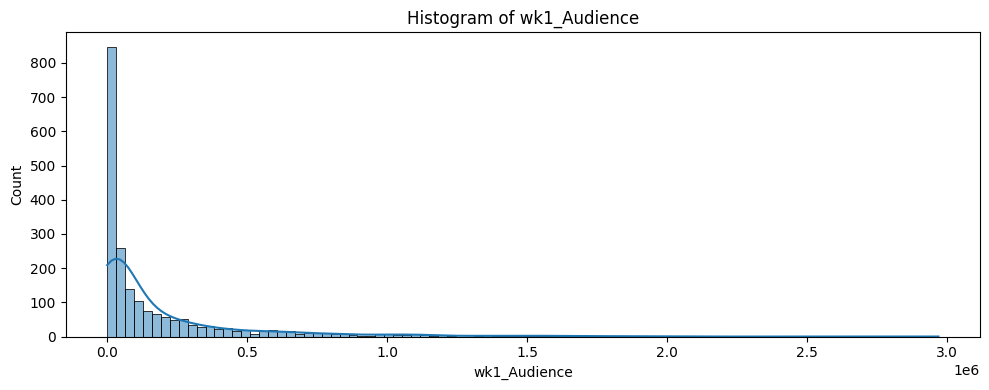

[wk1_Audience] skew=3.043, kurtosis=11.750
 -> wk1_Audience: 오른쪽 꼬리
--------------------------------------------------


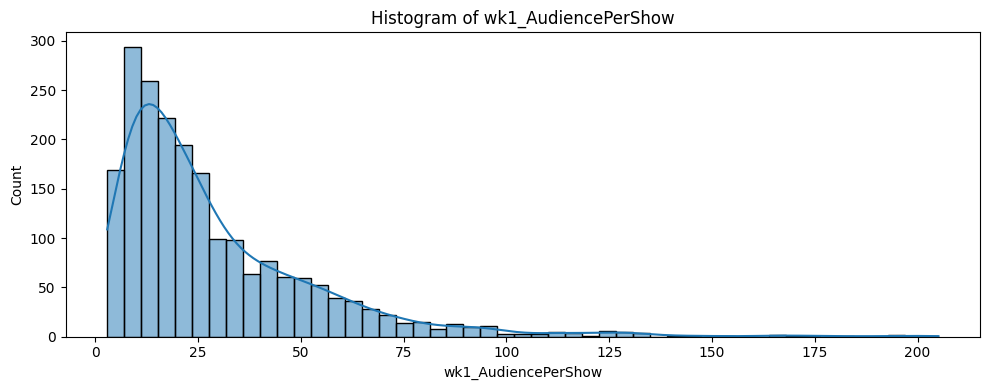

[wk1_AudiencePerShow] skew=2.240, kurtosis=7.437
 -> wk1_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


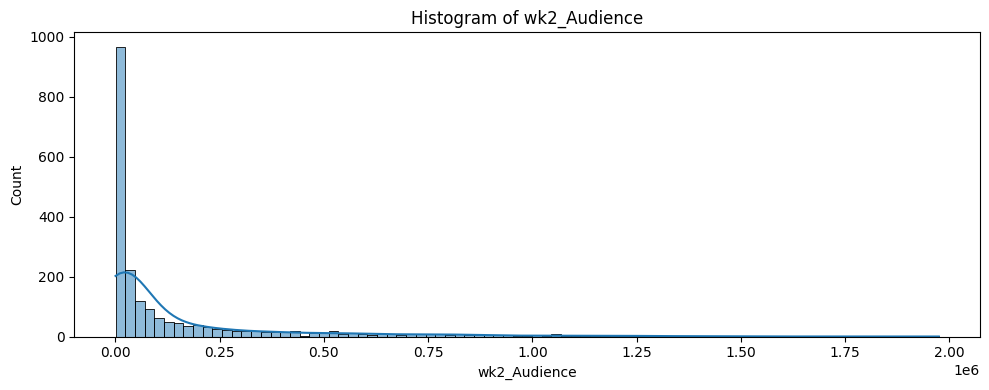

[wk2_Audience] skew=2.733, kurtosis=8.334
 -> wk2_Audience: 오른쪽 꼬리
--------------------------------------------------


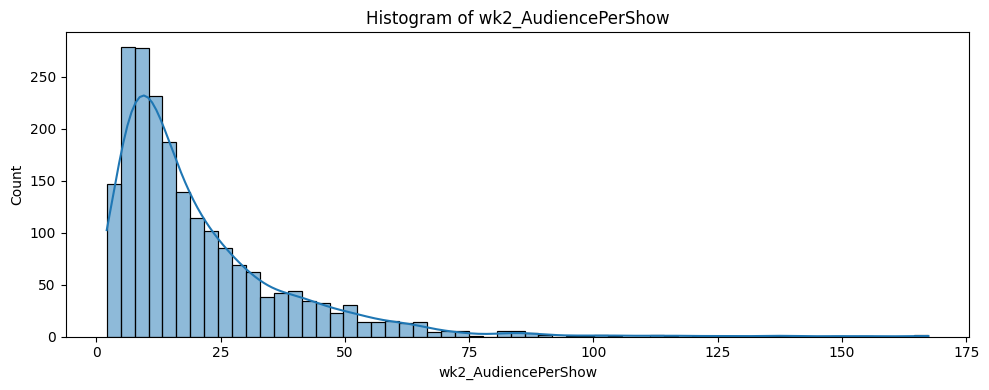

[wk2_AudiencePerShow] skew=2.615, kurtosis=11.106
 -> wk2_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


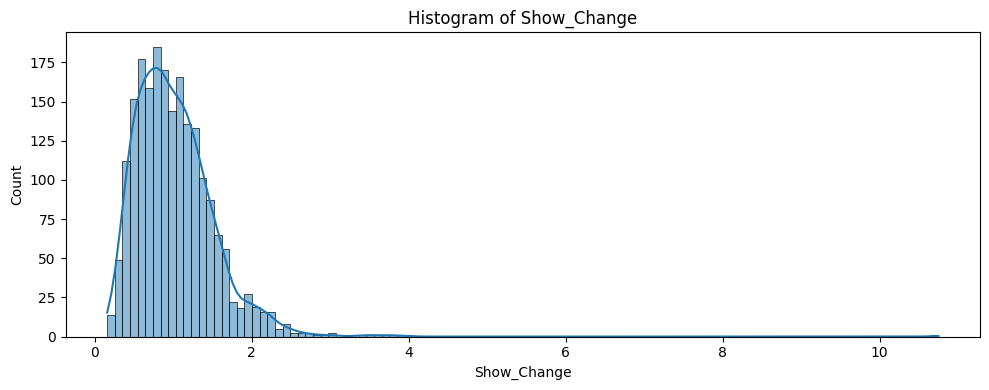

[Show_Change] skew=3.964, kurtosis=58.094
 -> Show_Change: 오른쪽 꼬리
--------------------------------------------------


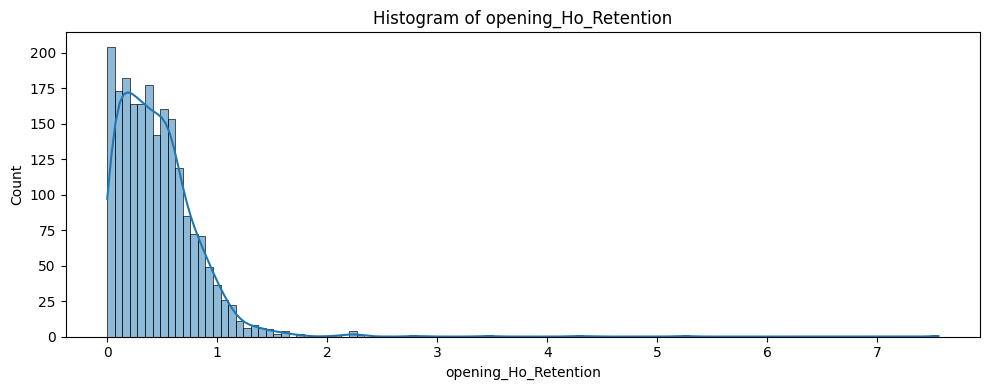

[opening_Ho_Retention] skew=5.087, kurtosis=68.229
 -> opening_Ho_Retention: 오른쪽 꼬리
--------------------------------------------------


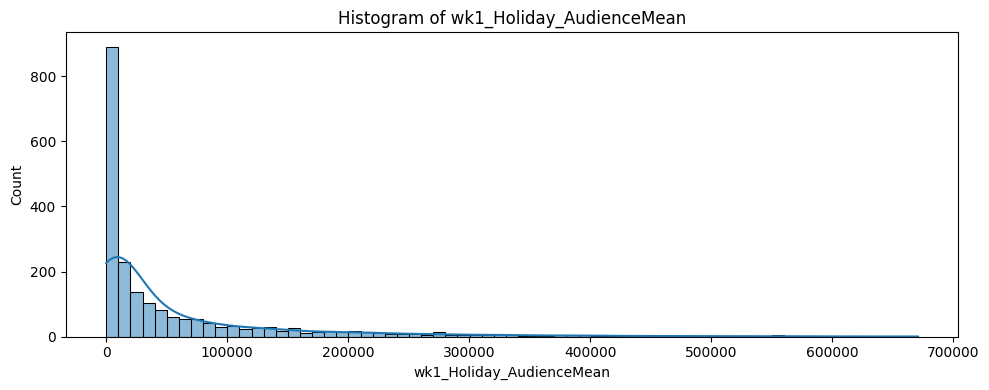

[wk1_Holiday_AudienceMean] skew=2.726, kurtosis=8.647
 -> wk1_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


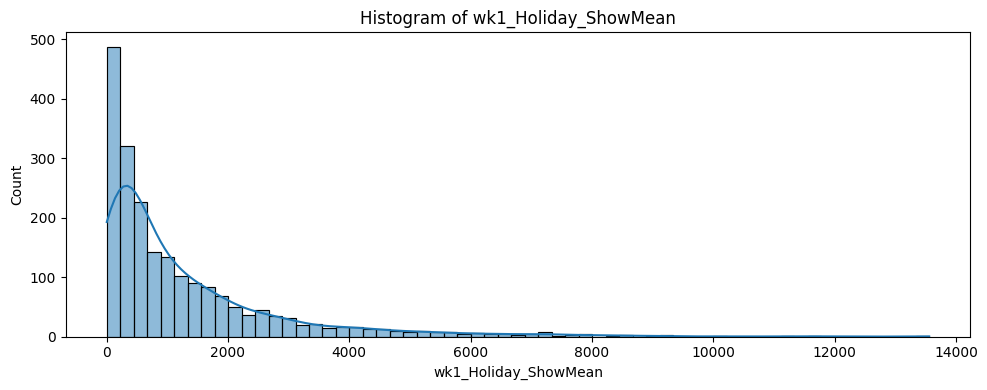

[wk1_Holiday_ShowMean] skew=2.481, kurtosis=8.184
 -> wk1_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


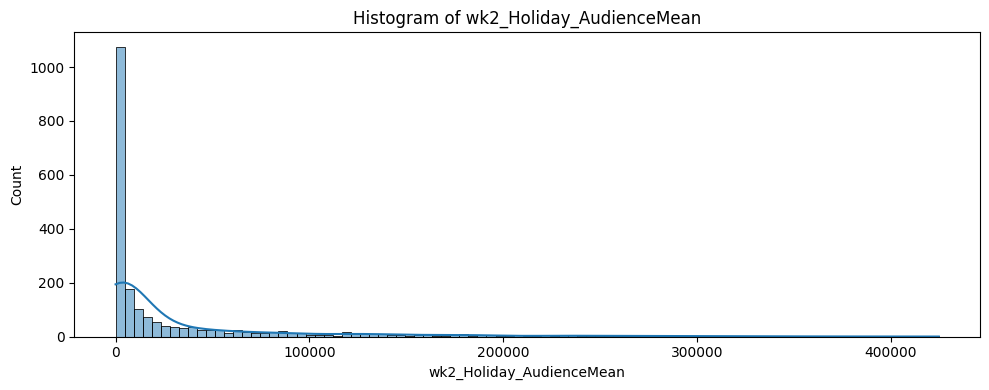

[wk2_Holiday_AudienceMean] skew=2.799, kurtosis=8.639
 -> wk2_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


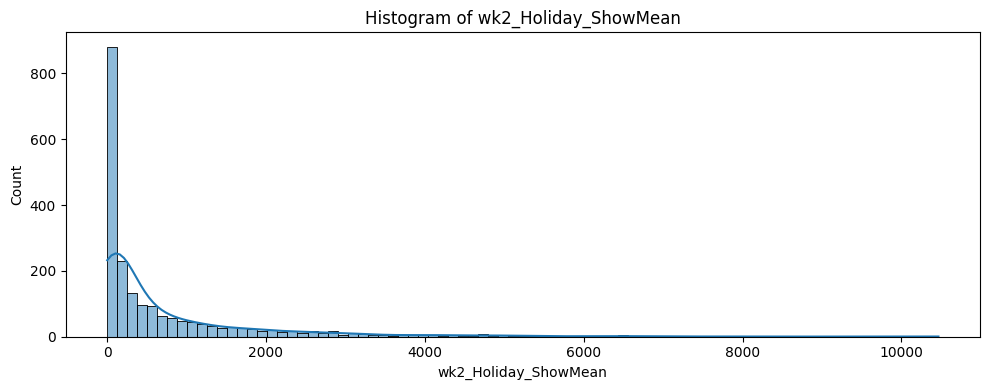

[wk2_Holiday_ShowMean] skew=2.811, kurtosis=10.300
 -> wk2_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


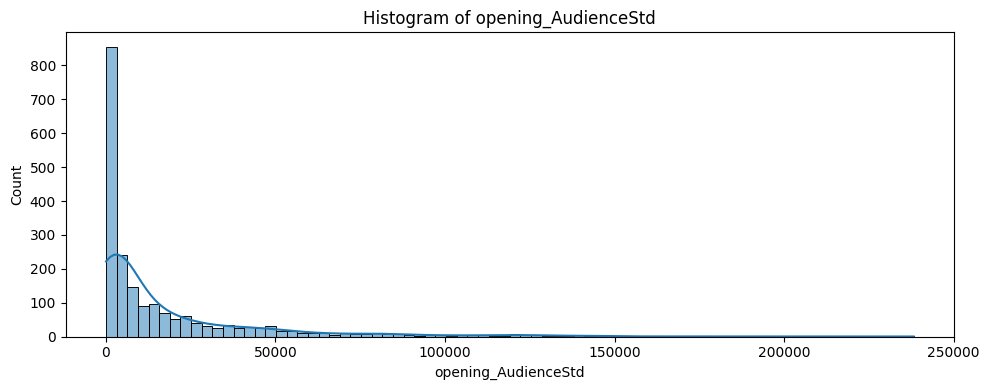

[opening_AudienceStd] skew=2.887, kurtosis=10.436
 -> opening_AudienceStd: 오른쪽 꼬리
--------------------------------------------------


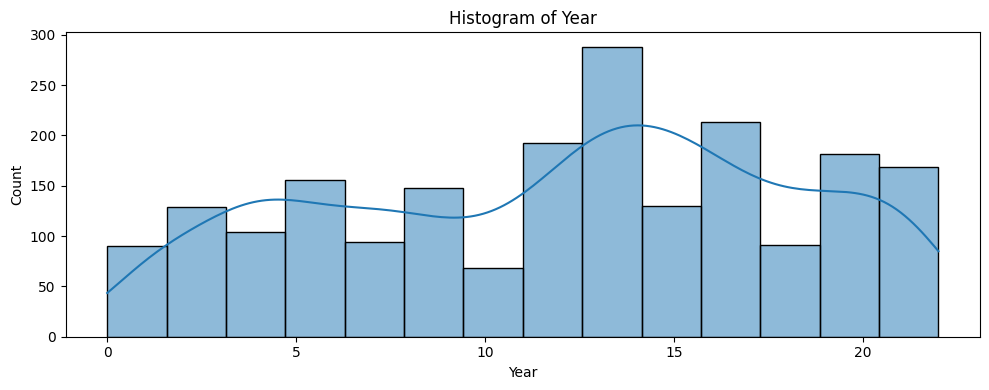

[Year] skew=-0.188, kurtosis=-1.058
 -> Year: 크게 안 치우침
--------------------------------------------------


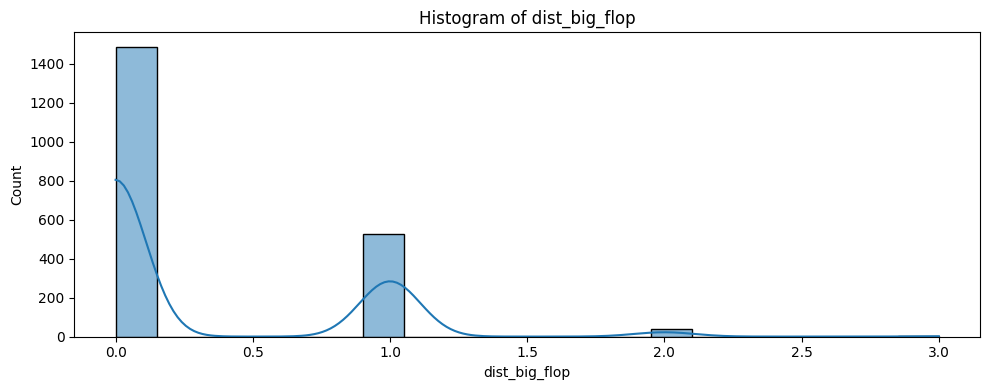

[dist_big_flop] skew=1.486, kurtosis=1.669
 -> dist_big_flop: 오른쪽 꼬리
--------------------------------------------------


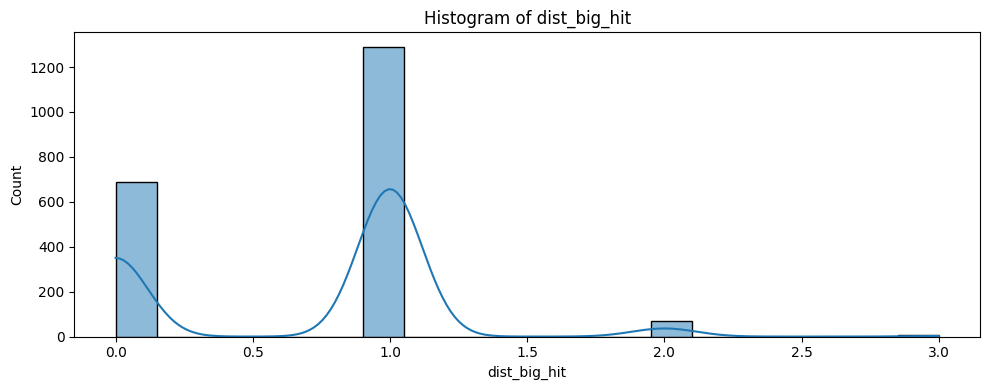

[dist_big_hit] skew=0.023, kurtosis=-0.040
 -> dist_big_hit: 크게 안 치우침
--------------------------------------------------


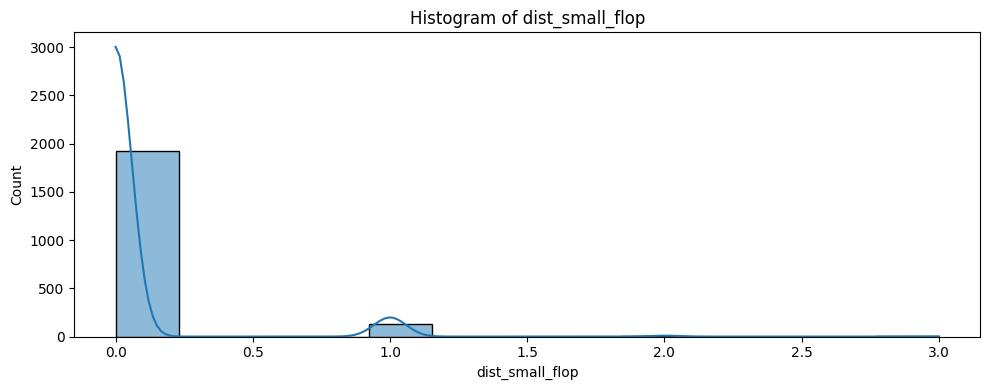

[dist_small_flop] skew=4.190, kurtosis=20.002
 -> dist_small_flop: 오른쪽 꼬리
--------------------------------------------------


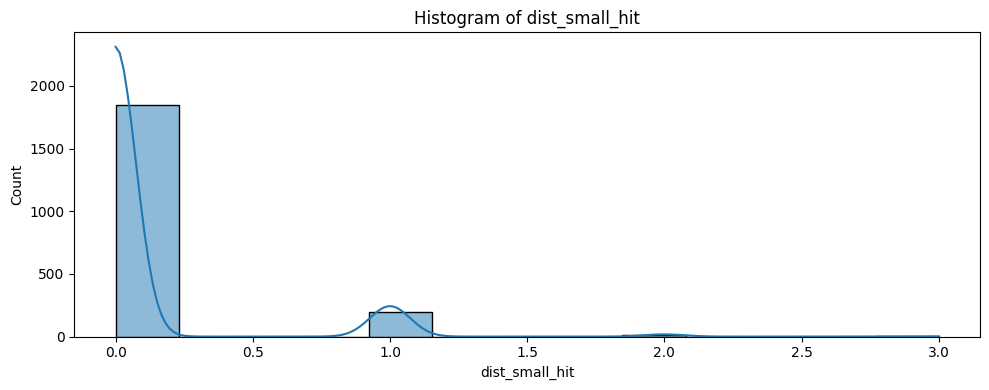

[dist_small_hit] skew=3.200, kurtosis=10.869
 -> dist_small_hit: 오른쪽 꼬리
--------------------------------------------------


In [16]:
for col in num_cols:
    data = X_train[col].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    
    # 히스토그램 + KDE
    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")
    fig.tight_layout()
    plt.show()

    # 왜도/첨도 계산
    sk = skew(data)
    ku = kurtosis(data)
    print(f"[{col}] skew={sk:.3f}, kurtosis={ku:.3f}")
    if sk > 1:
        print(f" -> {col}: 오른쪽 꼬리")
    elif sk < -1:
        print(f" -> {col}: 왼쪽 꼬리")
    else:
        print(f" -> {col}: 크게 안 치우침")
    print("-" * 50)

yeo-Johnson 테스트  
람다 값이 0에 가까울수록 로그변환, 1에 가까우면 변환 불필요

In [17]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(X_train[num_cols])

for col, lambda_ in zip(num_cols, pt.lambdas_):
    print(f"{col}: lambda = {lambda_:.4f}")

wk1_Audience: lambda = -0.0221
wk1_AudiencePerShow: lambda = -0.0984
wk2_Audience: lambda = -0.0946
wk2_AudiencePerShow: lambda = -0.1610
Show_Change: lambda = -0.7164
opening_Ho_Retention: lambda = -1.0974
wk1_Holiday_AudienceMean: lambda = -0.0179
wk1_Holiday_ShowMean: lambda = 0.1279
wk2_Holiday_AudienceMean: lambda = -0.0037
wk2_Holiday_ShowMean: lambda = 0.0188
opening_AudienceStd: lambda = 0.0121
Year: lambda = 0.9300
dist_big_flop: lambda = -4.1981
dist_big_hit: lambda = 0.8588
dist_small_flop: lambda = -21.3940
dist_small_hit: lambda = -13.5715


year을 제외하고 전부 제곱근 또는 로그변환을 하자

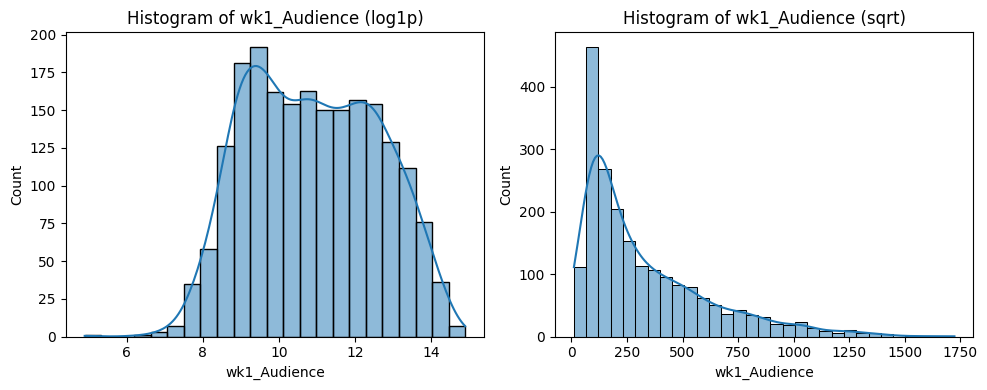

[wk1_Audience] skew_log1p=0.073, kurtosis_log1p=-0.910
 -> wk1_Audience: 크게 안 치우침
[wk1_Audience] skew_sqrt=1.448, kurtosis_sqrt=1.825
 -> wk1_Audience: 오른쪽 꼬리
--------------------------------------------------


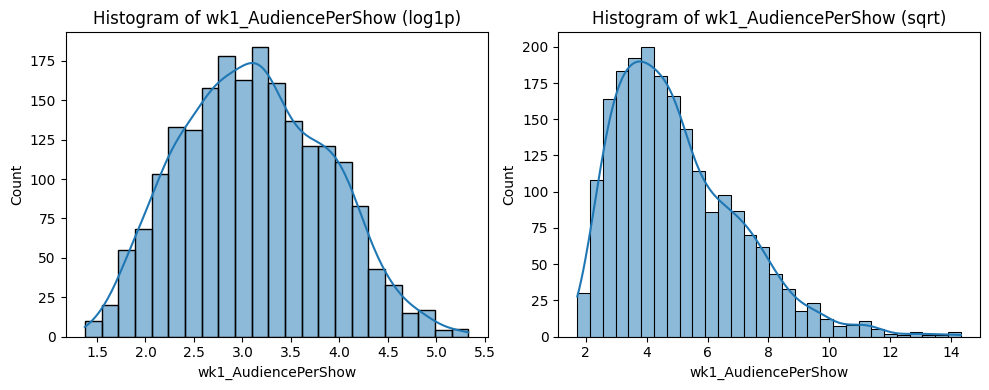

[wk1_AudiencePerShow] skew_log1p=0.170, kurtosis_log1p=-0.541
 -> wk1_AudiencePerShow: 크게 안 치우침
[wk1_AudiencePerShow] skew_sqrt=1.018, kurtosis_sqrt=1.152
 -> wk1_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


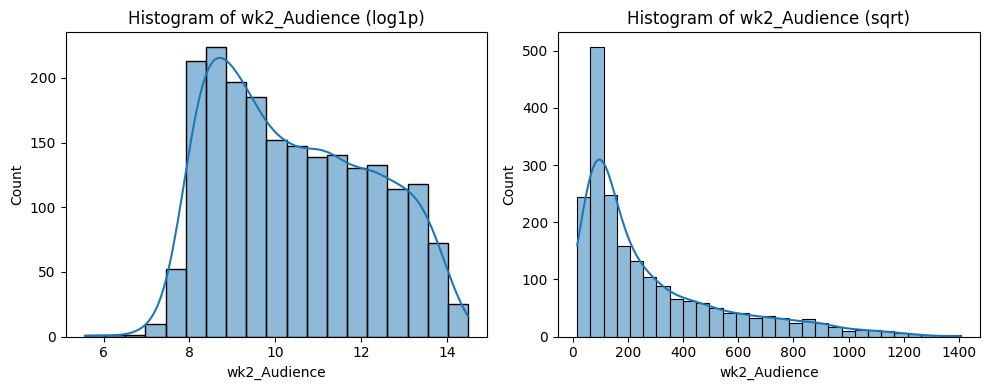

[wk2_Audience] skew_log1p=0.286, kurtosis_log1p=-1.051
 -> wk2_Audience: 크게 안 치우침
[wk2_Audience] skew_sqrt=1.486, kurtosis_sqrt=1.552
 -> wk2_Audience: 오른쪽 꼬리
--------------------------------------------------


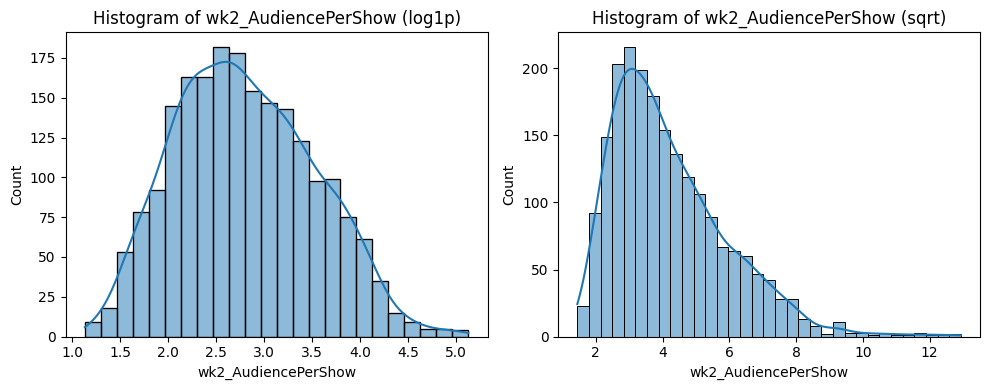

[wk2_AudiencePerShow] skew_log1p=0.274, kurtosis_log1p=-0.445
 -> wk2_AudiencePerShow: 크게 안 치우침
[wk2_AudiencePerShow] skew_sqrt=1.150, kurtosis_sqrt=1.770
 -> wk2_AudiencePerShow: 오른쪽 꼬리
--------------------------------------------------


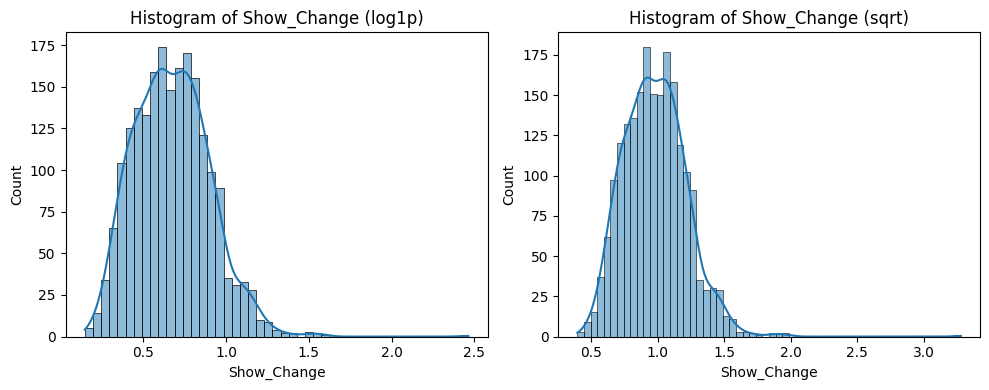

[Show_Change] skew_log1p=0.593, kurtosis_log1p=1.718
 -> Show_Change: 크게 안 치우침
[Show_Change] skew_sqrt=0.806, kurtosis_sqrt=4.325
 -> Show_Change: 크게 안 치우침
--------------------------------------------------


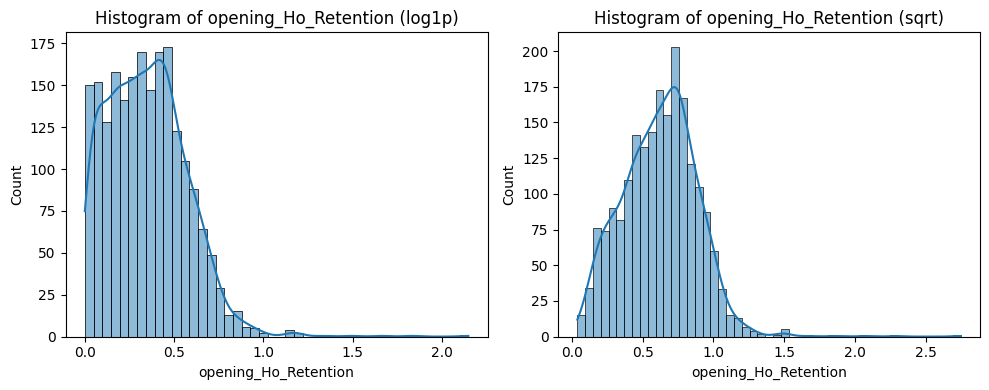

[opening_Ho_Retention] skew_log1p=0.970, kurtosis_log1p=3.600
 -> opening_Ho_Retention: 크게 안 치우침
[opening_Ho_Retention] skew_sqrt=0.525, kurtosis_sqrt=2.933
 -> opening_Ho_Retention: 크게 안 치우침
--------------------------------------------------


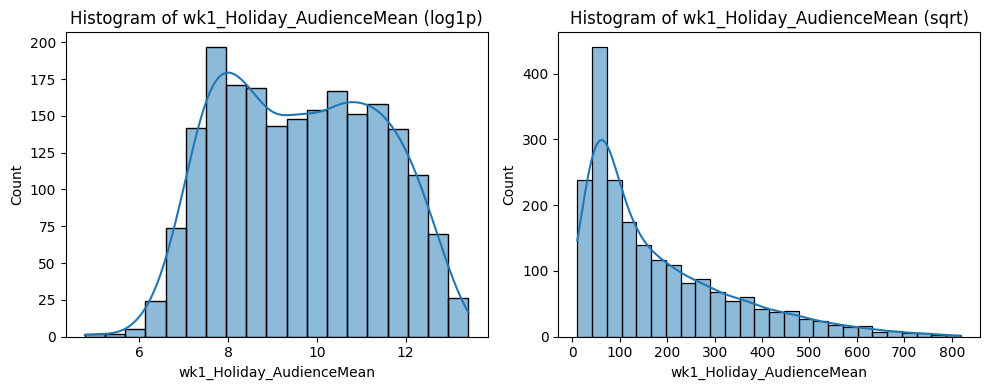

[wk1_Holiday_AudienceMean] skew_log1p=0.056, kurtosis_log1p=-1.032
 -> wk1_Holiday_AudienceMean: 크게 안 치우침
[wk1_Holiday_AudienceMean] skew_sqrt=1.338, kurtosis_sqrt=1.296
 -> wk1_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


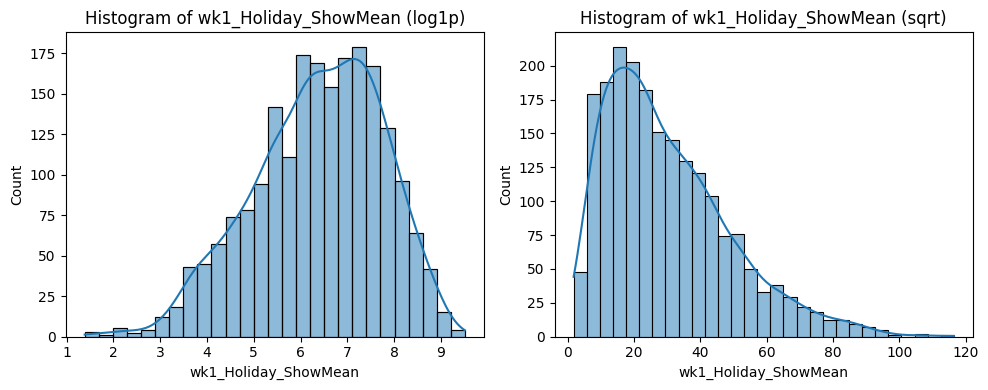

[wk1_Holiday_ShowMean] skew_log1p=-0.434, kurtosis_log1p=-0.189
 -> wk1_Holiday_ShowMean: 크게 안 치우침
[wk1_Holiday_ShowMean] skew_sqrt=1.016, kurtosis_sqrt=0.872
 -> wk1_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


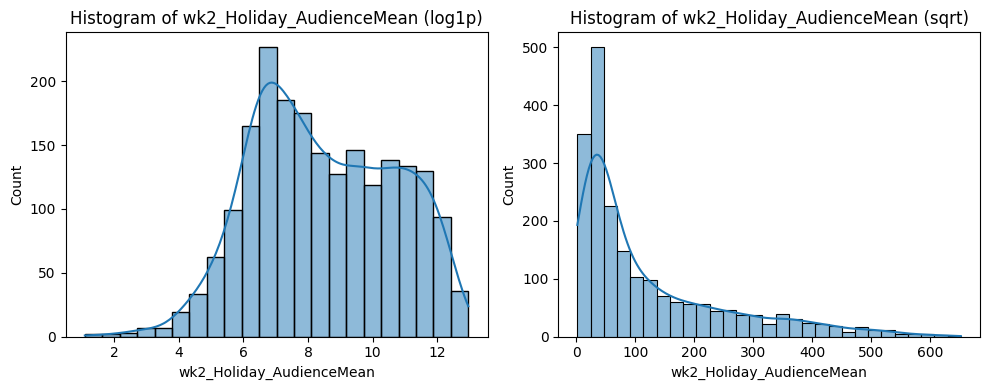

[wk2_Holiday_AudienceMean] skew_log1p=0.017, kurtosis_log1p=-0.772
 -> wk2_Holiday_AudienceMean: 크게 안 치우침
[wk2_Holiday_AudienceMean] skew_sqrt=1.516, kurtosis_sqrt=1.602
 -> wk2_Holiday_AudienceMean: 오른쪽 꼬리
--------------------------------------------------


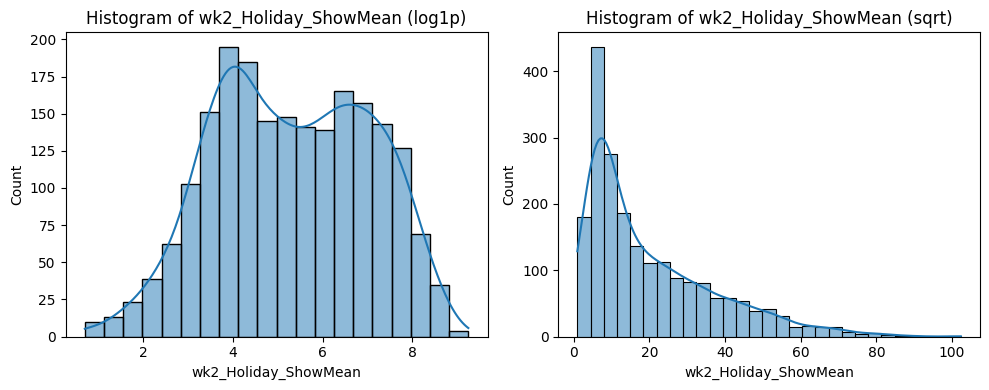

[wk2_Holiday_ShowMean] skew_log1p=-0.066, kurtosis_log1p=-0.831
 -> wk2_Holiday_ShowMean: 크게 안 치우침
[wk2_Holiday_ShowMean] skew_sqrt=1.286, kurtosis_sqrt=1.234
 -> wk2_Holiday_ShowMean: 오른쪽 꼬리
--------------------------------------------------


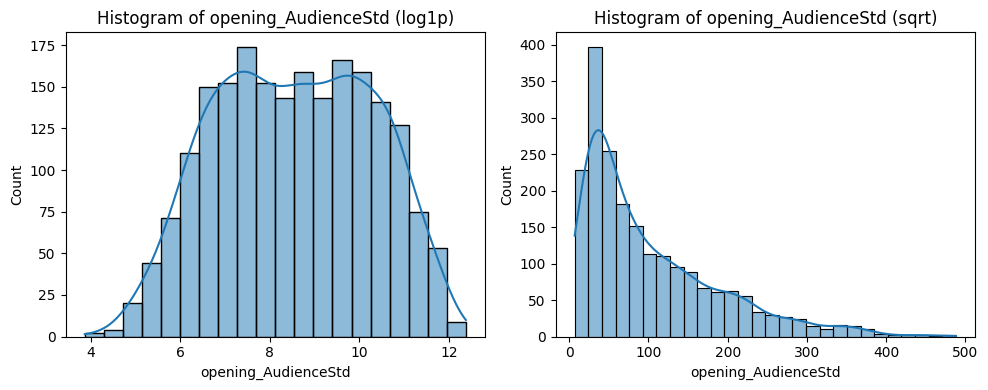

[opening_AudienceStd] skew_log1p=-0.040, kurtosis_log1p=-0.921
 -> opening_AudienceStd: 크게 안 치우침
[opening_AudienceStd] skew_sqrt=1.340, kurtosis_sqrt=1.464
 -> opening_AudienceStd: 오른쪽 꼬리
--------------------------------------------------


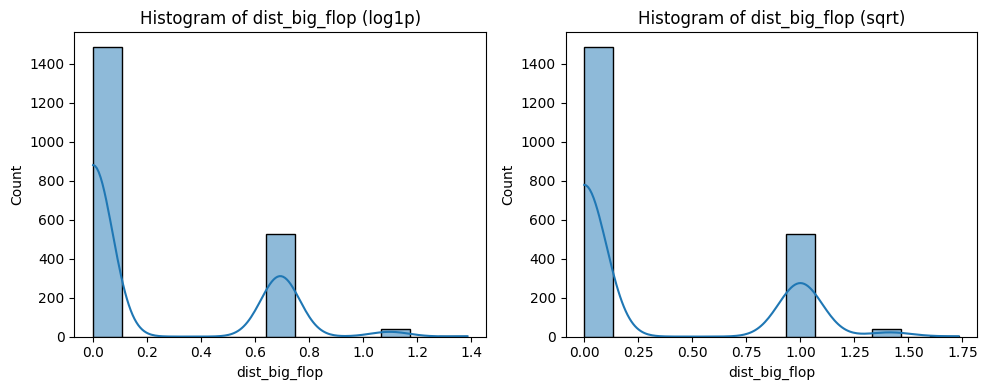

[dist_big_flop] skew_log1p=1.150, kurtosis_log1p=-0.312
 -> dist_big_flop: 오른쪽 꼬리
[dist_big_flop] skew_sqrt=1.074, kurtosis_sqrt=-0.680
 -> dist_big_flop: 오른쪽 꼬리
--------------------------------------------------


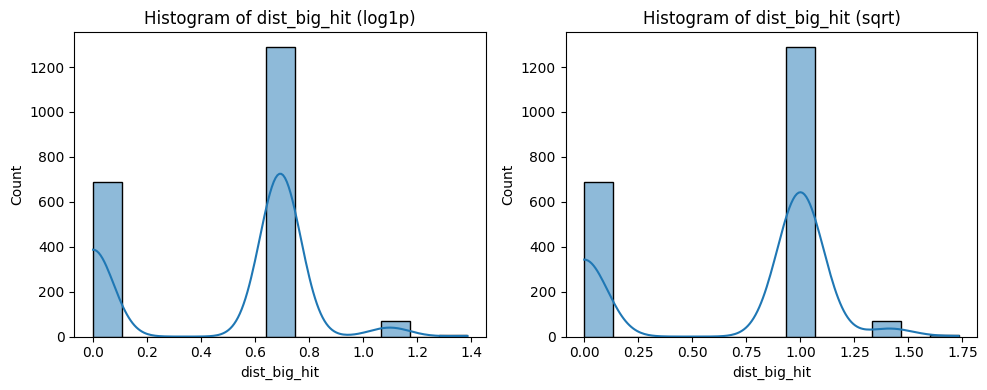

[dist_big_hit] skew_log1p=-0.470, kurtosis_log1p=-1.255
 -> dist_big_hit: 크게 안 치우침
[dist_big_hit] skew_sqrt=-0.585, kurtosis_sqrt=-1.418
 -> dist_big_hit: 크게 안 치우침
--------------------------------------------------


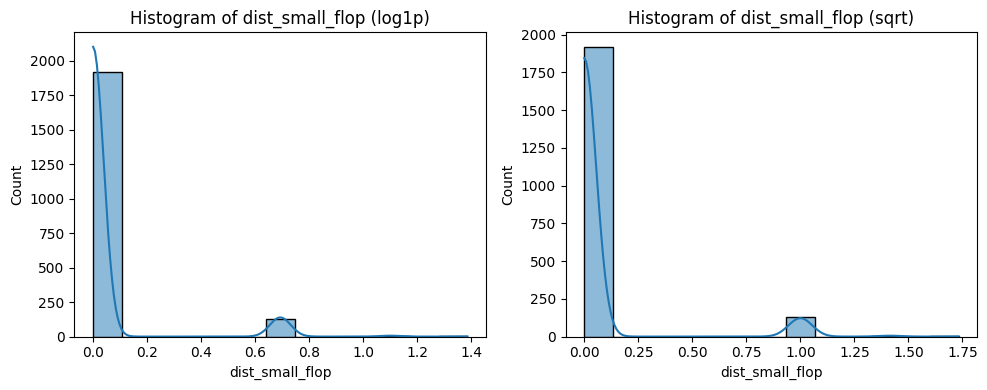

[dist_small_flop] skew_log1p=3.702, kurtosis_log1p=12.586
 -> dist_small_flop: 오른쪽 꼬리
[dist_small_flop] skew_sqrt=3.610, kurtosis_sqrt=11.414
 -> dist_small_flop: 오른쪽 꼬리
--------------------------------------------------


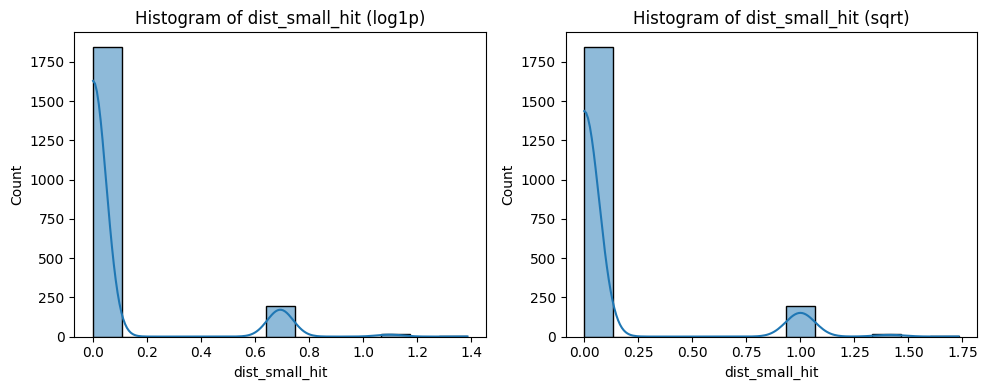

[dist_small_hit] skew_log1p=2.805, kurtosis_log1p=6.495
 -> dist_small_hit: 오른쪽 꼬리
[dist_small_hit] skew_sqrt=2.719, kurtosis_sqrt=5.670
 -> dist_small_hit: 오른쪽 꼬리
--------------------------------------------------


In [18]:
for col in [c for c in num_cols if c != 'Year']:
    data = X_train[col].dropna()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    #히스토그램 + KDE
    sns.histplot(np.log1p(data), kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram of {col} (log1p)")

    sns.histplot(np.sqrt(data), kde=True, ax=ax[1])
    ax[1].set_title(f"Histogram of {col} (sqrt)")

    plt.tight_layout()
    plt.show()

    # 왜도/첨도 계산
    sk_log1p = skew(np.log1p(data))
    ku_log1p = kurtosis(np.log1p(data))
    print(f"[{col}] skew_log1p={sk_log1p:.3f}, kurtosis_log1p={ku_log1p:.3f}")
    if sk_log1p > 1:
        print(f" -> {col}: 오른쪽 꼬리")
    elif sk_log1p < -1:
        print(f" -> {col}: 왼쪽 꼬리")
    else:
        print(f" -> {col}: 크게 안 치우침")
    sk_sqrt = skew(np.sqrt(data))
    ku_sqrt = kurtosis(np.sqrt(data))
    print(f"[{col}] skew_sqrt={sk_sqrt:.3f}, kurtosis_sqrt={ku_sqrt:.3f}")
    if sk_sqrt > 1:
        print(f" -> {col}: 오른쪽 꼬리")
    elif sk_sqrt < -1:
        print(f" -> {col}: 왼쪽 꼬리")
    else:
        print(f" -> {col}: 크게 안 치우침")
    print("-" * 50)

#### 결과
`opening_Ho_Retention`은 제곱근 변환  
`Year`, 배급사 관련 변수는 변환하지 않음  
나머지 변수는 로그 np.log1p 변환

In [19]:
log_cols=['wk1_Audience','wk1_AudiencePerShow','wk2_Audience','wk2_AudiencePerShow','Show_Change','wk1_Holiday_AudienceMean','wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean','wk2_Holiday_ShowMean','opening_AudienceStd']
sqrt_cols=['opening_Ho_Retention']
none_cols=['Year','dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols=['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Pandemic_1', 'Pandemic_2', 'Grade_15세이상관람가', 'Grade_전체관람가', 'Grade_청소년관람불가', 'Main_Country_미국', 'Main_Country_일본', 'Main_Country_한국']

In [20]:
X_full.loc[:, log_cols] = np.log1p(X_full[log_cols])
X_full.loc[:, sqrt_cols] = np.sqrt(X_full[sqrt_cols])

X_train.loc[:, log_cols] = np.log1p(X_train[log_cols])
X_train.loc[:, sqrt_cols] = np.sqrt(X_train[sqrt_cols])

/var/folders/5r/gp1130xx2t5fbxbgt43xtp_m0000gn/T/ipykernel_16623/2275203582.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7.98139158  9.8046612  12.63779337 ... 10.45708527 12.74164454
  8.80732227]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_full.loc[:, log_cols] = np.log1p(X_full[log_cols])
/var/folders/5r/gp1130xx2t5fbxbgt43xtp_m0000gn/T/ipykernel_16623/2275203582.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7.98139158  9.8046612  12.63779337 ...  9.28154413  8.14031554
  9.90348755]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, log_cols] = np.log1p(X_train[log_cols])


In [21]:
X_train.head()

,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Pandemic_1,Pandemic_2,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,9.061608,1.895248,7.981392,1.797480,0.322977,0.361635,7.475056,5.666427,5.444580,2.970414,6.668957,19,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,11.888351,3.655085,9.804661,2.754762,0.276557,0.427632,10.423627,6.729525,8.724776,5.337538,9.882714,13,1.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12.184650,4.539517,12.637793,4.201818,1.167784,0.944549,11.189285,6.563856,11.075190,6.537175,9.960560,2,0.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,13.717749,3.824695,12.355815,2.664616,0.620145,0.435824,12.399768,8.335911,10.738753,7.588070,11.576050,14,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,9.831454,1.812615,8.286521,1.525701,0.265327,0.167626,8.268219,6.487684,4.705016,2.351375,7.458380,16,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 표준화
선형 회귀이기 때문에 표준화를 사용한다.

#### 이상치와 왜도로 확인

In [22]:
for col in list(set(X_train.columns) - set(cat_cols)):
    #이상치
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((X_train[col] < Q1 - 1.5*IQR) | (X_train[col] > Q3 + 1.5*IQR)).mean()
    #왜도
    sk = skew(X_train[col])

    print(f"{col}: 이상치 비율 {outliers:.2%}, 왜도 {sk:.2f}")

wk2_Holiday_AudienceMean: 이상치 비율 0.05%, 왜도 0.02
Show_Change: 이상치 비율 0.63%, 왜도 0.59
wk2_Audience: 이상치 비율 0.00%, 왜도 0.29
dist_small_flop: 이상치 비율 6.52%, 왜도 4.19
opening_Ho_Retention: 이상치 비율 0.58%, 왜도 0.52
wk1_AudiencePerShow: 이상치 비율 0.00%, 왜도 0.17
Year: 이상치 비율 0.00%, 왜도 -0.19
wk1_Holiday_ShowMean: 이상치 비율 0.54%, 왜도 -0.43
dist_small_hit: 이상치 비율 10.18%, 왜도 3.20
opening_AudienceStd: 이상치 비율 0.00%, 왜도 -0.04
dist_big_flop: 이상치 비율 0.15%, 왜도 1.49
wk2_AudiencePerShow: 이상치 비율 0.29%, 왜도 0.27
wk1_Holiday_AudienceMean: 이상치 비율 0.00%, 왜도 0.06
dist_big_hit: 이상치 비율 0.24%, 왜도 0.02
wk2_Holiday_ShowMean: 이상치 비율 0.00%, 왜도 -0.07
wk1_Audience: 이상치 비율 0.05%, 왜도 0.07


이상치 비율이 5%이하이고 왜도가 1보다 작으면 standard, 둘 다 높으면 robust 사용

#### 결과
배급사 관련 변수는 robust 스케일러, 나머지는 모두 standard 스케일러를 사용한다

In [23]:

standard_cols = [
    'wk1_Audience','wk2_AudiencePerShow','wk1_Holiday_AudienceMean',
    'opening_AudienceStd','wk2_Audience',
    'wk2_Holiday_ShowMean','wk1_AudiencePerShow',
    'wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean',
    'Show_Change','Year','opening_Ho_Retention'
]

robust_cols = ['dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_cols),
        ('robust', RobustScaler(), robust_cols)
    ],
    remainder='passthrough'
)

X_train_scaled = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_full_scaled = pd.DataFrame(
    preprocessor.transform(X_full),
    columns=X_train.columns,
    index=X_full.index
)
X_full_scaled = pd.concat([X_full_scaled, X_full['index']], axis=1)

### 종속변수 변환

#### 분포

In [24]:
y_train.describe()

count    2.054000e+03
mean     4.685105e+05
std      8.243974e+05
min      1.001200e+04
25%      2.600300e+04
50%      9.929200e+04
75%      4.739828e+05
max      4.967201e+06
Name: Total_Audience_Count, dtype: float64

<Axes: xlabel='Total_Audience_Count', ylabel='Count'>

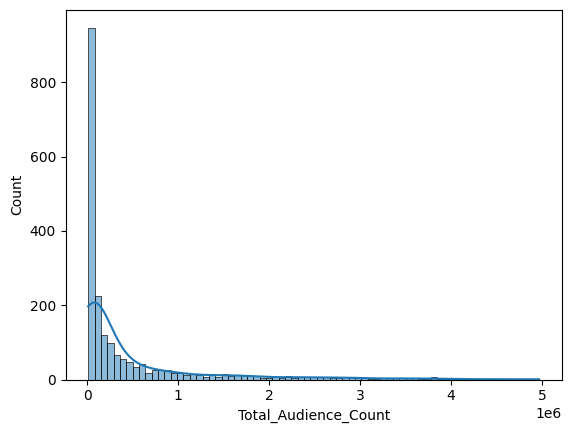

In [25]:
sns.histplot(y_train, kde=True)

심한 우측 꼬리 분포 -> 변환이 필요해 보인다

#### 잔차 확인

qq플롯, 잔차 플롯

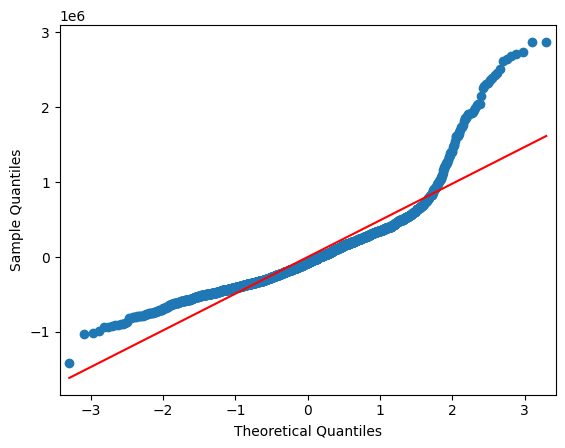

In [26]:
model = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()
fig = sm.qqplot(model.resid, line='s')
plt.show()

Text(0, 0.5, 'Residuals')

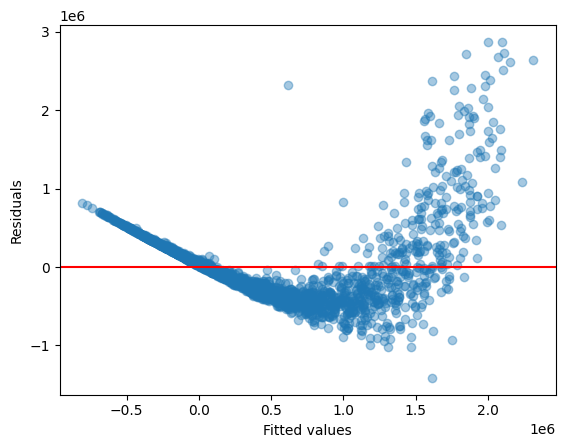

In [27]:
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

##### 제곱근 변환

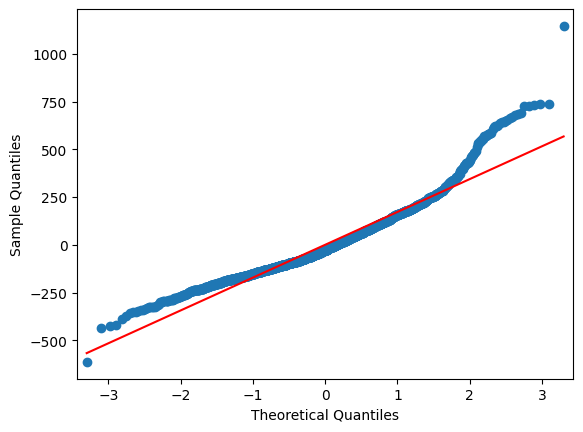

In [28]:
model = sm.OLS(np.sqrt(y_train), sm.add_constant(X_train_scaled)).fit()
fig = sm.qqplot(model.resid, line='s')

Text(0, 0.5, 'Residuals')

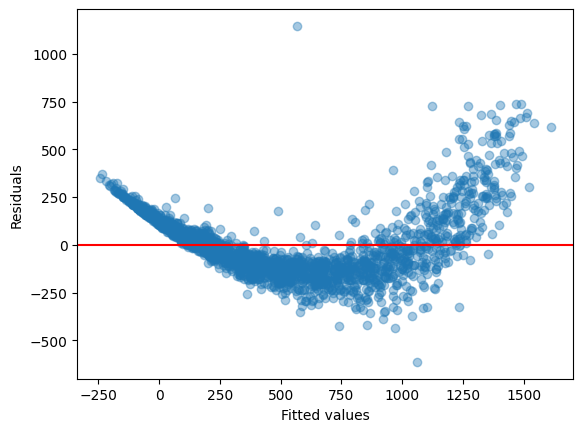

In [29]:
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

##### 로그 변환

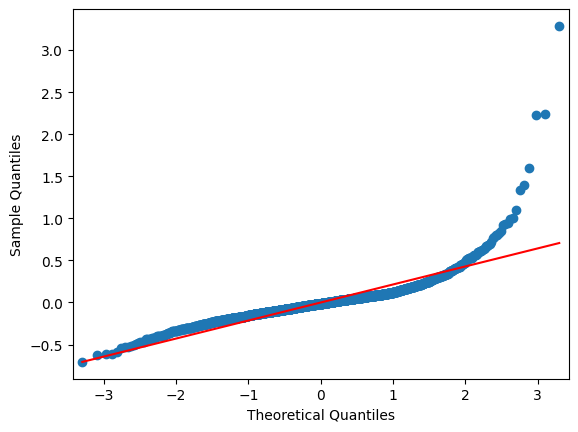

In [30]:
model = sm.OLS(np.log1p(y_train), sm.add_constant(X_train_scaled)).fit()
fig = sm.qqplot(model.resid, line='s')

Text(0, 0.5, 'Residuals')

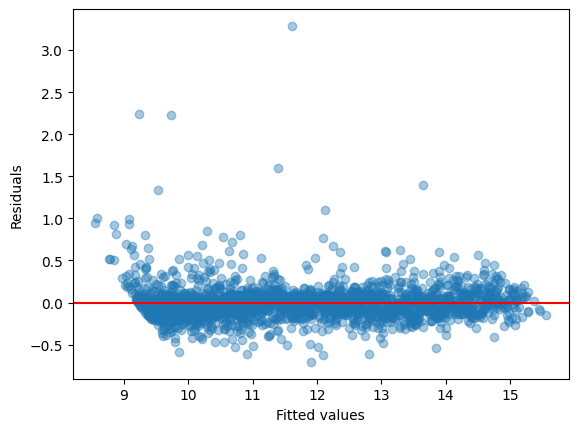

In [31]:
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

#### 결론

로그 변환을 사용한다  
다만 값의 범위가 큰 곳에서 이상치가 다량 발생한다

## 5) 다시 분리

몇개의 이상치가 있지만 로그 변환을 사용한다

In [32]:
X_train = X_full_scaled[X_full_scaled["index"] == 0].drop(columns=["index"])
X_test = X_full_scaled[X_full_scaled["index"] == 1].drop(columns=["index"])
X_predict = X_full_scaled[X_full_scaled["index"] == 2].drop(columns=["index"])

In [33]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# OLS - Total_Audience_Count

## 라소, 릿지, 엘라스틱넷

### 릿지 하이퍼파라미터 튜닝

In [34]:
alphas = np.logspace(-3, 1, 100)

In [35]:
ridge_cv = RidgeCV(
    alphas=alphas, 
    cv=5, # 5-겹 교차 검증 사용
    scoring='neg_mean_squared_error' # MSE 최소화
)
ridge_cv.fit(X_train, y_train)
y_pred_ridge_cv = ridge_cv.predict(X_test)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
ss_res_ridge_cv = np.sum((y_test - y_pred_ridge_cv) ** 2)
ss_tot_ridge_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_ridge_cv = 1 - ss_res_ridge_cv / ss_tot_ridge_cv
print("Optimal alpha (RidgeCV):", ridge_cv.alpha_)
print("MSE (RidgeCV):", mse_ridge_cv)
print("R^2 (RidgeCV):", r_squared_ridge_cv)

Optimal alpha (RidgeCV): 0.001
MSE (RidgeCV): 0.03925799347164423
R^2 (RidgeCV): 0.9867325907154801


### 라쏘 하이퍼파라미터 튜닝

In [36]:
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5, 
    random_state=42,
    max_iter=10000 # 수렴을 위해 반복 횟수 증가
)
lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = lasso_cv.predict(X_test)
mse_lasso_cv = mean_squared_error(y_test, y_pred_lasso_cv)
ss_res_lasso_cv = np.sum((y_test - y_pred_lasso_cv) ** 2)
ss_tot_lasso_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv.alpha_)
print("MSE (LassoCV):", mse_lasso_cv)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.001
MSE (LassoCV): 0.040878527111847036
R^2 (LassoCV): 0.9861849243381999


### 엘라스틱넷 하이퍼파라미터 튜닝

In [37]:
elastic_cv = ElasticNetCV(
    alphas=alphas,
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # L1/L2 비율 탐색 (1.0=Lasso)
    cv=5,
    random_state=42,
    max_iter=10000
)

elastic_cv.fit(X_train, y_train)
y_pred_elastic_cv = elastic_cv.predict(X_test)
mse_elastic_cv = mean_squared_error(y_test, y_pred_elastic_cv)
ss_res_elastic_cv = np.sum((y_test - y_pred_elastic_cv) ** 2)
ss_tot_elastic_cv = np.sum((y_test - y_test.mean()) ** 2)
r_squared_elastic_cv = 1 - ss_res_elastic_cv / ss_tot_elastic_cv
print("Optimal alpha (ElasticNetCV):", elastic_cv.alpha_)
print("Optimal l1_ratio (ElasticNetCV):", elastic_cv.l1_ratio_)
print("MSE (ElasticNetCV):", mse_elastic_cv)
print("R^2 (ElasticNetCV):", r_squared_elastic_cv)

Optimal alpha (ElasticNetCV): 0.001
Optimal l1_ratio (ElasticNetCV): 0.7
MSE (ElasticNetCV): 0.040621310750248794
R^2 (ElasticNetCV): 0.9862718517239937


### Test랑 비교

In [38]:
result_cv = pd.DataFrame([np.expm1(y_pred_ridge_cv), np.expm1(y_pred_lasso_cv), np.expm1(y_pred_elastic_cv), np.expm1(y_test.values)], index=['RidgeCV', 'LassoCV', 'ElasticNetCV', 'True']).round().astype(int).T
result_cv["ridge_diff"] = result_cv["True"] - result_cv["RidgeCV"]
result_cv["lasso_diff"] = result_cv["True"] - result_cv["LassoCV"]
result_cv["elastic_diff"] = result_cv["True"] - result_cv["ElasticNetCV"]
result_cv.sort_values(by='True', ascending=False)

,RidgeCV,LassoCV,ElasticNetCV,True,ridge_diff,lasso_diff,elastic_diff
131,4145235,4190838,4177023,4886764,741529,695926,709741
147,1845886,1796401,1810165,4692785,2846899,2896384,2882620
83,3764002,3711214,3711507,4673301,909299,962087,961794
303,4452980,4455968,4466208,4664509,211529,208541,198301
40,4550359,4537406,4547221,4560949,10590,23543,13728
...,...,...,...,...,...,...,...
473,12053,10973,11052,10161,-1892,-812,-891
124,9030,9597,9616,10135,1105,538,519
488,11172,10707,10776,10075,-1097,-632,-701
242,10162,10660,10533,10046,-116,-614,-487


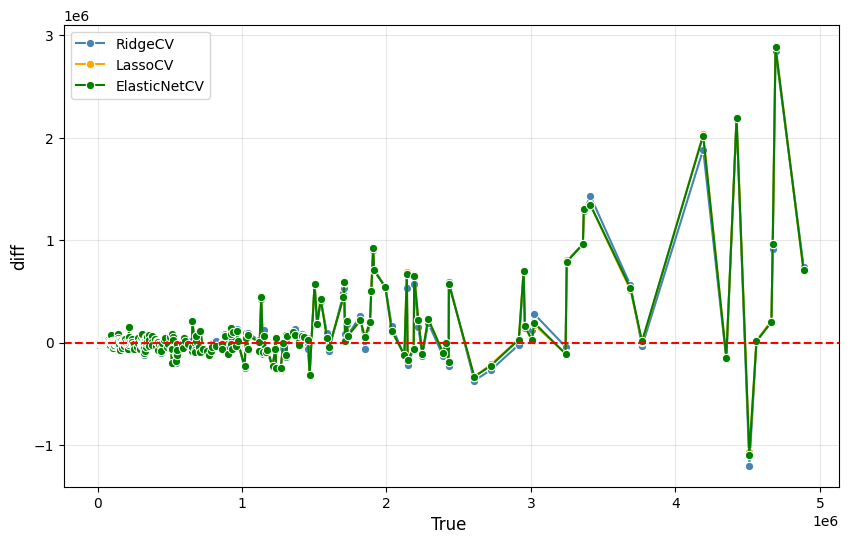

In [66]:
result_sorted = result_cv.sort_values(by='True', ascending=True)
result_sorted

plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='ridge_diff', data=result_sorted, marker='o', linewidth=1.5, color='steelblue', label='RidgeCV')
sns.lineplot(x='True', y='lasso_diff', data=result_sorted, marker='o', linewidth=1.5, color='orange', label='LassoCV')
sns.lineplot(x='True', y='elastic_diff', data=result_sorted, marker='o', linewidth=1.5, color='green', label='ElasticNetCV')
plt.legend()
plt.xlabel("True ", fontsize=12)
plt.ylabel("diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

### 결론
모델의 성능은 매우 높지만 과적합이 우려된다?  
위에 종속변수 로그 변환의 qq플롯을 보면, 값이 클수록 이상치로 탐지되는 것이 많았다.  
총 관객수가 높은 영화는 그 수가 적기도 하고, 영화 외적의 요인이 많기 때문인 것으로 사료된다.
여기서도 실제 총 관객수가 200만명을 기점으로 정답과 예측치간의 오차가 50만명 단위로 늘어난다.  
그것도 차이가 양수, 즉 더 적은 관객수로 예측을 하였기 때문에 문제가 발생한다.  
<br>
따라서 200만명 이상인 영화에 대해 총 관객수 예측 모델을 따로 구성하는것을 제안한다.

# over 2M predict

In [40]:
mask_2m_train = np.expm1(y_train) > 2_000_000
X_train_2m = X_train[mask_2m_train]
y_train_2m = y_train[mask_2m_train]

mask_2m_test = np.expm1(y_test) > 2_000_000
X_test_2m = X_test[mask_2m_test]
y_test_2m = y_test[mask_2m_test]

## 500만명 이상 영화도 추가
500만명 이상인 데이터는 보다 불안정하여 모델을 망칠 수 있다  
그러나 영화 외적인 요인을 보다 반영할 수 있을거라 기대된다

In [41]:
data_5m = pd.read_csv("../model_upper_5M_data.csv", encoding="utf-8-sig")

In [42]:
data_5m.drop(columns=e_list, inplace=True)


In [43]:
X_5m = data_5m.drop(columns = ["Movie_Title", "Total_Audience_Count", "Total_Show_Days", "Total_Weeks"])
y_5m = data_5m["Total_Audience_Count"]

원핫인코딩

In [44]:
num_cols = ['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols = ['Month', 'Pandemic', 'Grade', 'Main_Country']
X_5m = pd.get_dummies(X_5m, columns=cat_cols, drop_first=True)
onehot_columns = [col for col in X_5m.columns if any(prefix in col for prefix in ['Month_', 'Pandemic_', 'Grade_', 'Main_Country_'])]
X_5m[onehot_columns] = X_5m[onehot_columns].astype(int)

연도 변환

In [45]:
X_5m["Year"] = X_5m["Year"] - X_5m["Year"].min()

수치형 독립변수 변환

In [46]:
log_cols=['wk1_Audience','wk1_AudiencePerShow','wk2_Audience','wk2_AudiencePerShow','Show_Change','wk1_Holiday_AudienceMean','wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean','wk2_Holiday_ShowMean','opening_AudienceStd']
sqrt_cols=['opening_Ho_Retention']
none_cols=['Year','dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']
cat_cols=['Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Pandemic_1', 'Pandemic_2', 'Grade_15세이상관람가', 'Grade_전체관람가', 'Grade_청소년관람불가', 'Main_Country_미국', 'Main_Country_일본', 'Main_Country_한국']

X_5m.loc[:, log_cols] = np.log1p(X_5m[log_cols])
X_5m.loc[:, sqrt_cols] = np.sqrt(X_5m[sqrt_cols])

/var/folders/5r/gp1130xx2t5fbxbgt43xtp_m0000gn/T/ipykernel_16623/42836997.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14.57968547 14.31151692 14.37750067 15.37297494 14.45539936 14.47151491
 15.2375921  14.61719954 14.78668864 13.74880436 15.268155   15.04929048
 14.18115942 14.81854726 14.51392882 15.23982178 15.1116217  14.50043452
 14.65252429 14.26471692 14.42737176 15.20606135 14.35698041 14.34041363
 15.61365609 13.96660027 14.40923567 15.17024382 15.00438942 15.00043448
 15.12638878 14.47272896 15.17188809 15.06977383 14.96137977 14.94542834
 14.15120178 14.83156698 14.96276157 13.7938803  13.94487867 14.74967107
 14.97944887 14.37988415 14.67833342 14.85166252 13.49483273 14.40004472
 13.76708683 14.35267446 14.22766988 13.99504991 14.52437507 14.16030379
 14.77829701 14.8934435  14.33594705 14.31483449 14.290052   14.4875536
 14.40931961 13.89628192 14.26243554 14.42805433 14.61545128 15.08996904


없는 컬럼 탐색

In [47]:
set(X_train.columns) - set(X_5m.columns)

{'Main_Country_미국'}

없는 데이터를 새로 생성한다

In [48]:
X_5m["Main_Country_미국"] = 0

표준화

In [49]:
standard_cols = [
    'wk1_Audience','wk2_AudiencePerShow','wk1_Holiday_AudienceMean',
    'opening_AudienceStd','wk2_Audience',
    'wk2_Holiday_ShowMean','wk1_AudiencePerShow',
    'wk1_Holiday_ShowMean','wk2_Holiday_AudienceMean',
    'Show_Change','Year','opening_Ho_Retention'
]

robust_cols = ['dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit']

X_5m_scaled = pd.DataFrame(
    preprocessor.transform(X_5m),
    columns=X_5m.columns,
    index=X_5m.index
)

종속변수 로그변환

In [50]:
y_5m = np.log1p(y_5m)

### 두 데이터 합치기

In [51]:
X_train_5m, X_test_5m, y_train_5m, y_test_5m = train_test_split(X_5m_scaled, y_5m, test_size=0.2, random_state=42)

In [52]:
X_train_2m = pd.concat([X_train_2m, X_train_5m], axis=0)
y_train_2m = pd.concat([y_train_2m, y_train_5m], axis=0)
X_test_2m = pd.concat([X_test_2m, X_test_5m], axis=0)
y_test_2m = pd.concat([y_test_2m, y_test_5m], axis=0)

In [53]:
print(len(y_train_2m), len(y_test_2m))

200 51


비율도 8:2로 유지되었다

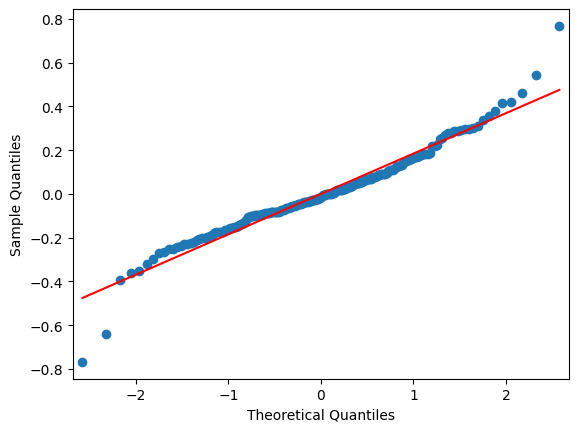

In [54]:
model = sm.OLS(y_train_2m, sm.add_constant(X_train_2m)).fit()
fig = sm.qqplot(model.resid, line='s')

로그변환한 것의 qq플롯에선 양 끝점에 이상치가 발생하였지만 그리 우려할 정도는 아니라고 판단된다

## 예측

### 엘라스틱넷

In [55]:
param_grid = {
    'alpha': np.concatenate([
        np.logspace(-4, -1, 50),
        np.logspace(-1, 1, 50)
    ]),
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

grid = GridSearchCV(
    estimator=ElasticNet(max_iter=1000000, random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', #이상치가 많기 때문에 MAE 사용
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_2m, y_train_2m)

elastic_cv_2m = grid.best_estimator_
y_pred_elastic_cv_2m = elastic_cv_2m.predict(X_test_2m)
mae_elastic_cv_2m = mean_absolute_error(y_test_2m, y_pred_elastic_cv_2m)
ss_res_elastic_cv = np.sum((y_test_2m - y_pred_elastic_cv_2m) ** 2)
ss_tot_elastic_cv = np.sum((y_test_2m - y_test_2m.mean()) ** 2)
r_squared_elastic_cv_2m = 1 - ss_res_elastic_cv / ss_tot_elastic_cv
print("Optimal alpha (ElasticNetCV):", elastic_cv_2m.l1_ratio)
print("MAE (ElasticNetCV):", mae_elastic_cv_2m)
print("R^2 (ElasticNetCV):", r_squared_elastic_cv_2m)

Optimal alpha (ElasticNetCV): 1.0
MAE (ElasticNetCV): 0.20675076509836407
R^2 (ElasticNetCV): 0.7469524911823878


엘라스틱의 결과 라쏘(l1)회귀만 사용한다

In [56]:
alphas = np.unique(np.concatenate([
    np.logspace(-4, -1, 50),
    np.logspace(-1, 1, 50)
]))

grid = GridSearchCV(
    estimator=Lasso(max_iter=1000000, random_state=42),
    param_grid={'alpha': alphas},
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_2m, y_train_2m)

lasso_cv_2m = grid.best_estimator_
y_pred_lasso_cv_2m = lasso_cv_2m.predict(X_test_2m)
mae_lasso_cv_2m = mean_absolute_error(y_test_2m, y_pred_lasso_cv_2m)
ss_res_lasso_cv = np.sum((y_test_2m - y_pred_lasso_cv_2m) ** 2)
ss_tot_lasso_cv = np.sum((y_test_2m - y_test_2m.mean()) ** 2)
r_squared_lasso_cv = 1 - ss_res_lasso_cv / ss_tot_lasso_cv
print("Optimal alpha (LassoCV):", lasso_cv_2m.alpha)
print("MAE (LassoCV):", mae_lasso_cv_2m)
print("R^2 (LassoCV):", r_squared_lasso_cv)

Optimal alpha (LassoCV): 0.0001
MAE (LassoCV): 0.20675076509836407
R^2 (LassoCV): 0.7469524911823878


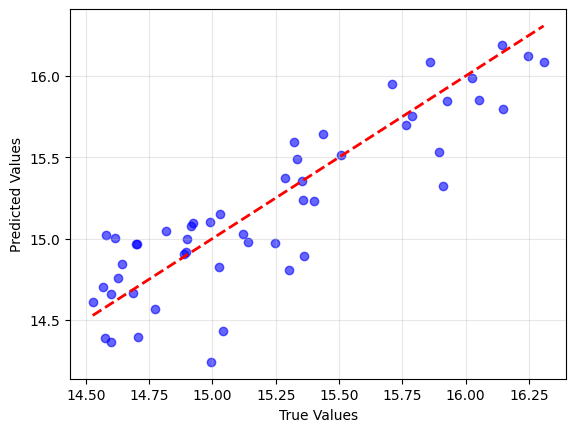

In [57]:
plt.scatter(y_test_2m, y_pred_elastic_cv_2m, alpha=0.6, label='ElasticNetCV', color='blue')
plt.plot([y_test_2m.min(), y_test_2m.max()], [y_test_2m.min(), y_test_2m.max()], 'r--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

### XGBoost

In [58]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # cross_val_predict로 fold별 예측 생성
    y_pred_log = cross_val_predict(model, X_train_2m, y_train_2m,
                                   cv=kf, n_jobs=-1, verbose=0)

    # 예측값은 log 스케일 → 역변환 필요
    y_true = np.expm1(y_train_2m)      # 실제 관객 수
    y_pred = np.expm1(y_pred_log)      # 예측 관객 수

    # 성능 계산
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # R²를 Optuna에 로그로 저장
    trial.set_user_attr("r2", r2)

    return mae   # MAE를 최소화


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=7200)

best_trial = study.best_trial

print("Best params:", best_trial.params)
print("Best MAE:", best_trial.value)
print("Best R²:", best_trial.user_attrs["r2"])


/Users/swoo64/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-05 15:56:52,270] A new study created in memory with name: no-name-61579579-a9e6-45b4-aad6-e6760bd42997
[I 2025-11-05 15:56:52,408] Trial 0 finished with value: 1215996.6887499997 and parameters: {'n_estimators': 1481, 'learning_rate': 0.0591889480218292, 'max_depth': 3, 'min_child_weight': 3.719695830985111, 'subsample': 0.5068564843962464, 'colsample_bytree': 0.6289063669225159, 'gamma': 2.6868131704351077, 'reg_alpha': 0.00014423387352929787, 'reg_lambda': 24.20560579987858}. Best is trial 0 with value: 1215996.6887499997.
[I 2025-11-05 15:56:52,556] Trial 1 finished with value: 1049219.6562499998 and parameters: {'n_estimators': 1648, 'learning_rate': 0.15935349116855232, 'max_depth': 6, 'min_child_weight': 9.04950881

Best params: {'n_estimators': 1583, 'learning_rate': 0.06797326587680862, 'max_depth': 4, 'min_child_weight': 3.2483937485833, 'subsample': 0.5632658008547711, 'colsample_bytree': 0.9932641550747743, 'gamma': 0.008415842210232088, 'reg_alpha': 0.0006222724626167664, 'reg_lambda': 0.008802928179235833}
Best MAE: 639939.6325
Best R²: 0.8548277916873961


In [59]:
# 최적 파라미터로 모델 생성
best_params = study.best_trial.params

best_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42
)
best_model.fit(X_train_2m, y_train_2m)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9932641550747743
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [60]:
y_pred_xgb_2m = best_model.predict(X_test_2m)
y_pred = np.expm1(y_pred_xgb_2m)
y_true = np.expm1(y_test_2m)

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Final MAE: {mae:,.0f}")
print(f"Final R²: {r2:.4f}")

Final MAE: 741,257
Final R²: 0.8467


### Test랑 비교

In [61]:
result_cv_2m = pd.DataFrame([np.expm1(y_pred_lasso_cv_2m), np.expm1(y_pred_xgb_2m), np.expm1(y_test_2m.values)], index=['LassoCV', 'XGB', 'True']).round().astype(int).T
result_cv_2m["lasso_diff_2"] = result_cv_2m["True"] - result_cv_2m["LassoCV"]
result_cv_2m["xgb_diff"] = result_cv_2m["True"] - result_cv_2m["XGB"]

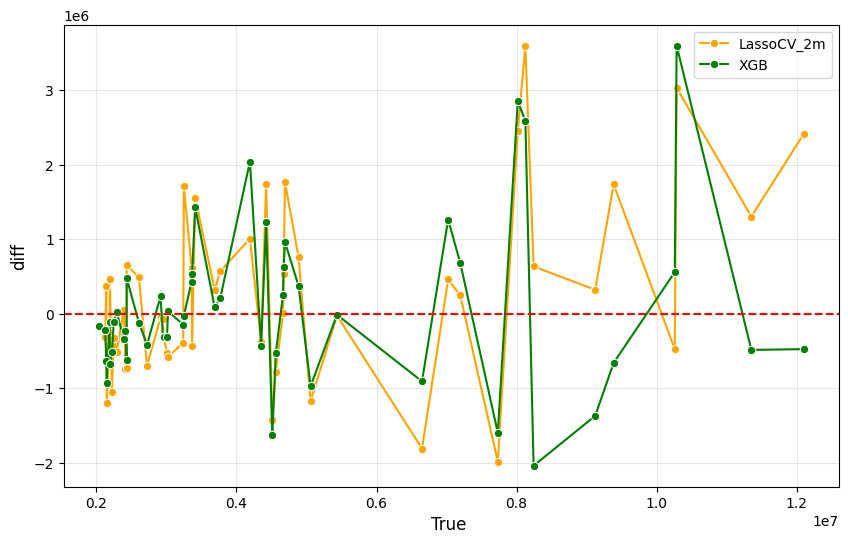

In [65]:
result_sorted = result_cv_2m.sort_values(by='True', ascending=True)
result_sorted

plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='lasso_diff_2', data=result_sorted, marker='o', linewidth=1.5, color='orange', label='LassoCV_2m')
sns.lineplot(x='True', y='xgb_diff', data=result_sorted, marker='o', linewidth=1.5, color='green', label='XGB')
plt.legend()
plt.xlabel("True ", fontsize=12)
plt.ylabel("diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

# 두 총 관객 예측 모델 비교 - 200만명 이상만

In [63]:
temp1 = result_cv[result_cv["True"] > 2000000].reset_index(drop=True)[["True", "ridge_diff", "lasso_diff", "elastic_diff"]]
temp2 = result_cv_2m[result_cv_2m["True"] > 2000000].reset_index(drop=True)[["True", "lasso_diff_2", "xgb_diff"]]
temp = pd.merge(temp1, temp2, on="True")

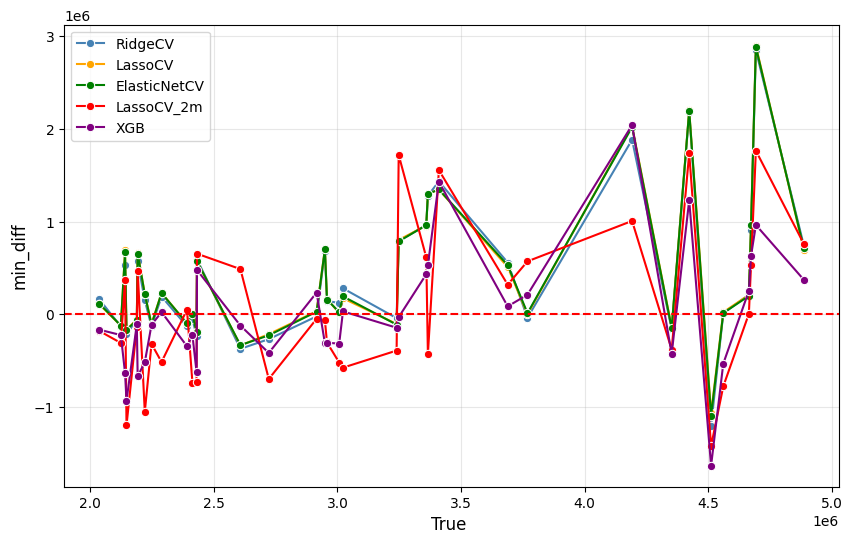

In [67]:
plt.figure(figsize=(10,6))
sns.lineplot(x='True', y='ridge_diff', data=temp, marker='o', linewidth=1.5, color='steelblue', label='RidgeCV')
sns.lineplot(x='True', y='lasso_diff', data=temp, marker='o', linewidth=1.5, color='orange', label='LassoCV')
sns.lineplot(x='True', y='elastic_diff', data=temp, marker='o', linewidth=1.5, color='green', label='ElasticNetCV')
sns.lineplot(x='True', y='lasso_diff_2', data=temp, marker='o', linewidth=1.5, color='red', label='LassoCV_2m')
sns.lineplot(x='True', y='xgb_diff', data=temp, marker='o', linewidth=1.5, color='purple', label='XGB')
plt.legend()
plt.xlabel("True ", fontsize=12)
plt.ylabel("min_diff", fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.grid(alpha=0.3)
plt.show()

결과가 여전히 좋진 않다. 영화 외부적인 요인으로 인해 그런 듯 하다  
그러면, 예측이 잘 안된 것은, 예측이 잘 된 것과 뚜렷히 구분되는 특징을 보여주지 않을까?  
이것이 영화 외부 요인이 되지 않을까?